## Setup

In [ ]:
class TrainConfig:
    max_depth = 80                          # God's Number
    batch_size_per_depth = 1000
    num_steps = 1000
    learning_rate = 1e-3
    INTERVAL_PLOT, INTERVAL_SAVE = 100, 1000
    ENABLE_FP16 = False                     # Set this to True if you want to train the model faster

class SearchConfig:
    beam_width = 2**11                      # This controls the trade-off between time and optimality
    max_depth = TrainConfig.max_depth * 2   # Any number above God's Number will do
    ENABLE_FP16 = False                     # Set this to True if you want to solve faster

In [ ]:
# from tqdm import tqdm
# import time

# # Example loop with tqdm
# for i in tqdm(range(10)):
#     # Simulate some work
#     time.sleep(0.1)

# # Alternatively, you can use tqdm with any iterable
# my_list = [1, 2, 3, 4, 5]
# for item in tqdm(my_list, desc="Processing items"):
#     # Do some processing on each item
#     time.sleep(0.2)


In [ ]:
import os
import time
import random
import pickle
import numpy as np
from copy import deepcopy
from contextlib import nullcontext
from tqdm import tqdm, trange

import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
from torch import nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'device: {device}')
print(f'os.cpu_count(): {os.cpu_count()}')
!nvidia-smi -L

device: cuda
os.cpu_count(): 2
GPU 0: Tesla T4 (UUID: GPU-f4cd7cff-9437-1143-5b6f-c1d6c7847aa5)


## Environment
15 Puzzle is ...

In [ ]:
class Puzzle15:
    def __init__(self):
        self.DTYPE = np.int64

        # define state and goal
        self.reset() # state
        self.goal = np.concatenate((np.arange(1, 4 * 4, dtype=self.DTYPE), [0])) #Array of 1 to 16 16 as 0

        self.moves = ['U', 'D', 'L', 'R']
        self.moves_inference = ['D','U','R','L']

        # opposite faces
        self.pairing = {
            'R':'L',
            'L':'R',
            'U':'D',
            'D':'U',
        }
        self.moves_available_after = {
            m:[v for v in self.moves if v!=self.pairing[m]] for m in self.moves
        }

        # [OPTIMIZATION] slicing by move string => indices
        self.moves_ix = [self.moves.index(m) for m in self.moves]
        self.moves_ix_available_after = {
            self.moves.index(m): [self.moves.index(m) for m in available_moves]
            for m, available_moves in self.moves_available_after.items()
        }
        self.moves_ix_inference = [self.moves.index(m) for m in self.moves_inference]
        self.pairing_ix = {
            0:1,
            1:0,
            2:3,
            3:2
        }

        # vectorize the sticker group replacement operations
        self.__vectorize_moves()

    def reset(self):
        self.state = np.concatenate((np.arange(1, 4 * 4, dtype=self.DTYPE), [0]))

    def is_solved(self):
        return np.all(self.state == self.goal)

    def finger(self, move):
        if isinstance(move, str):
            move = self.moves.index(move)
        self.finger_ix(move)

    def finger_ix(self, move):
        # [target] empty slot
        target_index = np.squeeze(np.where(self.state == 0))
        # [source] to-be empty slot
        source_index = self.swap_zeros[target_index, move] # `self.swap_zeros`: defined in `__vectorize_moves`
        # Swap.
        self.state[target_index], self.state[source_index] = self.state[source_index], 0

    def apply_scramble(self, scramble):
        if isinstance(scramble, str):
            scramble = scramble.split()
        for m in scramble:
            self.finger(m)

    def scrambler(self, scramble_length):
        """
            A generator function yielding the state and scramble
        """
        while True:
            # reset the self.state, scramble, and retun self.state and scramble moves
            self.reset()
            scramble = []
            for i in range(scramble_length):
                target_loc = np.where(self.state.reshape(4, 4) == 0)
                for _ in iter(int,1):
                    if scramble:    # [2nd~ move]
                        move = random.choice(self.moves_ix_available_after[scramble[-1]])
                    else:           # [1st move]
                        move = random.choice(self.moves_ix)
                    """
                    index_map:
                        [ 0  1  2  3]
                        [ 4  5  6  7]
                        [ 8  9 10 11]
                        [12 13 14 15]
                    """
                    # Skip ineffective moves
                    if move==3: # if move=="R"
                        if target_loc[1]:
                            # zero_index NOT on the left
                            break
                    elif move==1: # if move=="D"
                        if target_loc[0]:
                            # zero_index NOT be at the top
                            break
                    elif move==0: # if move=="U"
                        if target_loc[0]!=4-1:
                            # zero_index NOT on the left
                            break
                    elif move==2: # if move=="L"
                        if target_loc[1]!=4-1:
                            # zero_index NOT on the left
                            break
                    else:
                        raise ValueError("Unexpected move index.")

                self.finger_ix(move)
                scramble.append(move)
                yield self.state, move

    def __vectorize_moves(self):
        # Code retrieved & modified from:
        # https://github.com/forestagostinelli/DeepCubeA/blob/f75918a5fb83c140b649ee634f765d42845b17a3/environments/n_puzzle.py#L174
        self.swap_zeros = np.zeros((4*4, len(self.moves)), dtype=self.DTYPE)
        for move_ix, move in enumerate(self.moves):
            for i in range(4):
                for j in range(4):
                    z_idx = np.ravel_multi_index((i, j), (4, 4))
                    state = np.ones((4, 4), dtype=np.int64)
                    state[i, j] = 0

                    is_eligible = False
                    if move == 'U':
                        is_eligible = i < (4 - 1)
                    elif move == 'D':
                        is_eligible = i > 0
                    elif move == 'L':
                        is_eligible = j < (4 - 1)
                    elif move == 'R':
                        is_eligible = j > 0

                    if is_eligible:
                        swap_i, swap_j = -1, -1
                        if move == 'U':
                            swap_i = i + 1
                            swap_j = j
                        elif move == 'D':
                            swap_i = i - 1
                            swap_j = j
                        elif move == 'L':
                            swap_i = i
                            swap_j = j + 1
                        elif move == 'R':
                            swap_i = i
                            swap_j = j - 1

                        self.swap_zeros[z_idx, move_ix] = np.ravel_multi_index((swap_i, swap_j), (4, 4))
                    else:
                        self.swap_zeros[z_idx, move_ix] = z_idx

env = Puzzle15()

## Model

In [ ]:
class LinearBlock(nn.Module):
    """
    Linear layer with ReLU and BatchNorm
    """
    def __init__(self, input_prev, embed_dim):
        super(LinearBlock, self).__init__()
        self.fc = nn.Linear(input_prev, embed_dim)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm1d(embed_dim)

    def forward(self, inputs):
        x = inputs
        x = self.fc(x)
        x = self.relu(x)
        x = self.bn(x)
        return x

class ResidualBlock(nn.Module):
    """
    Residual block with two linear layers
    """
    def __init__(self, embed_dim):
        super(ResidualBlock, self).__init__()
        self.layers = nn.ModuleList([
            LinearBlock(embed_dim, embed_dim),
            LinearBlock(embed_dim, embed_dim)
        ])

    def forward(self, inputs):
        x = inputs
        for layer in self.layers:
            x = layer(x)
        x += inputs # skip-connection
        return x

class Model(nn.Module):

    def __init__(self, input_dim=16**2, output_dim=len(env.moves)):
        super(Model, self).__init__()
        self.input_dim = input_dim
        self.embedding = LinearBlock(input_dim, 5000)
        self.layers = nn.ModuleList([
            LinearBlock(5000,1000),
            ResidualBlock(1000),
            ResidualBlock(1000),
            ResidualBlock(1000),
            ResidualBlock(1000)
        ])
        self.output = nn.Linear(1000, output_dim)

    def forward(self, inputs):
        # int indices => float one-hot vectors
        x = nn.functional.one_hot(inputs, num_classes=16).to(torch.float)
        x = x.reshape(-1, self.input_dim)
        x = self.embedding(x)
        for layer in self.layers:
            x = layer(x)
        logits = self.output(x)
        return logits

model = Model().to(device)

## Training

In [ ]:
class ScrambleGenerator(torch.utils.data.Dataset):
    def __init__(
            self,
            num_workers=os.cpu_count(),
            max_depth=TrainConfig.max_depth,
            total_samples=TrainConfig.num_steps*TrainConfig.batch_size_per_depth
        ):
        self.num_workers = num_workers
        self.max_depth = max_depth
        self.envs = [Puzzle15() for _ in range(num_workers)]
        self.generators = [env.scrambler(self.max_depth) for env in self.envs]

        self.total_samples = total_samples

    def __len__(self):
        return self.total_samples

    def __getitem__(self, i):
        'generate one scramble, consisting of `self.max_depth` data points'
        worker_idx = i % self.num_workers
        X = np.zeros((self.max_depth, 16), dtype=int)
        y = np.zeros((self.max_depth,), dtype=int)
        for j in range(self.max_depth):
            state, last_move = next(self.generators[worker_idx])
            X[j, :] = state
            y[j] = last_move
        return X, y

dataloader = torch.utils.data.DataLoader(
    ScrambleGenerator(),
    num_workers=os.cpu_count(),
    batch_size=TrainConfig.batch_size_per_depth
)

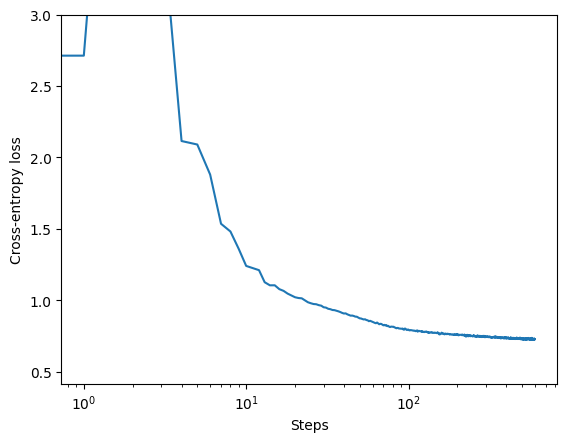

 66%|██████▌   | 662/1000 [22:44<11:36,  2.06s/it]

In [ ]:
def plot_loss_curve(h):
    fig, ax = plt.subplots(1, 1)
    ax.plot(h)
    ax.set_xlabel("Steps")
    ax.set_ylabel("Cross-entropy loss")
    ax.set_xscale("log")
    ax.set_ylim(top=3.) # prevent initial high loss values from dominating the plot
    plt.show()

def train(model, dataloader):
    model.train()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=TrainConfig.learning_rate)
    g = iter(dataloader)
    h = []
    ctx = torch.cuda.amp.autocast(dtype=torch.float16) if TrainConfig.ENABLE_FP16 else nullcontext()

    for i in trange(1, TrainConfig.num_steps + 1, smoothing=0):
        batch_x, batch_y = next(g)
        batch_x, batch_y = batch_x.reshape(-1, 16).to(device), batch_y.reshape(-1).to(device)

        with ctx:
            pred_y = model(batch_x)
            loss = loss_fn(pred_y, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        h.append(loss.item())
        if TrainConfig.INTERVAL_PLOT and i % TrainConfig.INTERVAL_PLOT == 0:
            clear_output()
            plot_loss_curve(h)
        if TrainConfig.INTERVAL_SAVE and i % TrainConfig.INTERVAL_SAVE == 0:
            torch.save(model.state_dict(), f"{i}steps.pth")
            print("Model saved.")
    print(f"Trained on data equivalent to {TrainConfig.batch_size_per_depth * TrainConfig.num_steps} solves.")
    return model

model = train(model, dataloader)

## Inference

We test and compare on the DeepCubeA dataset

### Dataset: DeepCubeA

Downloading from GitHub

In [ ]:
if "DeepCubeA"!=os.getcwd().split("/")[-1]:
    if not os.path.exists('DeepCubeA'):
        !git clone -q https://github.com/forestagostinelli/DeepCubeA
    %cd ./DeepCubeA/

print('### Optimal Solver ###')
filename = 'data/puzzle15/test/data_0.pkl'
with open(filename, 'rb') as f:
    result_Optimal = pickle.load(f)

    print(result_Optimal.keys())
    result_Optimal["solution_lengths"] = [len(s) for s in result_Optimal["solutions"]]
    result_Optimal["solution_lengths_count"] = {
        i: result_Optimal["solution_lengths"].count(i)
        for i in range(min(result_Optimal["solution_lengths"]), max(result_Optimal["solution_lengths"]))
    }

    print('No. of cases:', len(result_Optimal["solution_lengths"]))

print('\n### DeepCubeA ###')
filename = 'results/puzzle15/results.pkl'
with open(filename, 'rb') as f:
    result_DeepCubeA = pickle.load(f)

    print(result_DeepCubeA.keys())
    result_DeepCubeA["solution_lengths"] = [len(s) for s in result_DeepCubeA["solutions"]]
    result_DeepCubeA["solution_lengths_count"] = {
        i: result_DeepCubeA["solution_lengths"].count(i)
        for i in range(min(result_DeepCubeA["solution_lengths"]), max(result_DeepCubeA["solution_lengths"]))
    }

    print('No. of cases:', len(result_DeepCubeA["solution_lengths"]))

%cd ../

In [ ]:
# Convert optimal solutions to test scrambles
def solution2scramble(solution):
    return [env.pairing[m] for m in solution[::-1]]

test_scrambles = [solution2scramble(s) for s in result_Optimal["solutions"]]

print(f"""Example:\n{result_Optimal["solutions"][0]}\n-> {test_scrambles[0]}""")

### Beam Search

In [ ]:
@torch.no_grad()
def beam_search(
        env,
        model,
        beam_width=SearchConfig.beam_width,
        max_depth=SearchConfig.max_depth,
        skip_redundant_moves=True,
    ):
    """
    Best-first search algorithm.
    Input:
        env: A scrambled instance of the given environment.
        model: PyTorch model used to predict the next move(s).
        beam_width: Number of top solutions to return per depth.
        max_depth: Maximum depth of the search tree.
        skip_redundant_moves: If True, skip redundant moves.
    Output:
        if solved successfully:
            True, {'solutions':solution path, "num_nodes_generated":number of nodes expanded, "times":time taken to solve}
        else:
            False, None
    """
    model.eval()
    with torch.cuda.amp.autocast(dtype=torch.float16) if SearchConfig.ENABLE_FP16 else nullcontext():
        # metrics
        num_nodes_generated, time_0 = 0, time.time()
        candidates = [
            {"state":deepcopy(env.state), "path":[], "value":1.}
        ] # list of dictionaries

        for depth in range(max_depth+1):
            # TWO things at a time for every candidate: 1. check if solved & 2. add to batch_x
            batch_x = np.zeros((len(candidates), env.state.shape[-1]), dtype=np.int64)
            for i,c in enumerate(candidates):
                c_path, env.state = c["path"], c["state"]
                if c_path:
                    env.finger_ix(c_path[-1])
                    num_nodes_generated += 1
                    if env.is_solved():
                        # Revert: array of indices => array of notations
                        c_path = [str(env.moves[i]) for i in c_path]
                        return True, {'solutions':c_path, "num_nodes_generated":num_nodes_generated, "times":time.time()-time_0}
                batch_x[i, :] = env.state

            # after checking the nodes expanded at the deepest
            if depth==max_depth:
                print("Solution not found.")
                return False, None

            # make predictions with the trained DNN
            batch_x = torch.from_numpy(batch_x).to(device)
            batch_p = model(batch_x)
            batch_p = torch.nn.functional.softmax(batch_p, dim=-1)
            batch_p = batch_p.detach().cpu().numpy()

            # loop over candidates
            candidates_next_depth = []  # storage for the depth-level candidates storing (path, value, index).
            for i, c in enumerate(candidates):
                c_path = c["path"]
                value_distribution = batch_p[i, :] # output logits for the given state
                value_distribution *= c["value"] # multiply the cumulative probability so far of the expanded path

                for m, value in zip(env.moves_ix_inference, value_distribution): # iterate over all possible moves.
                    # predicted value to expand the path with the given move.

                    # Skip **physically** illegal moves (whether you like it or not)
                    target_loc = np.where(c['state'].reshape(4, 4) == 0)
                    if m==3: # if m=="R"
                        if not target_loc[1]: # zero_index (empty slot) on the left
                            continue
                    elif m==1: # if m=="D"
                        if not target_loc[0]: # on the top
                            continue
                    elif m==0: # if m=="U"
                        if target_loc[0]==3: # on the bottom
                            continue
                    elif m==2: # if m=="L"
                        if target_loc[1]==3: # on the right
                            continue

                    if c_path and skip_redundant_moves:
                        # Two cancelling moves
                        if env.pairing_ix[c_path[-1]] == m:
                            continue

                    # add to the next-depth candidates unless 'continue'd.
                    candidates_next_depth.append({
                        'state':deepcopy(c['state']),
                        "path": c_path+[m],
                        "value":value,
                    })

            # sort potential paths by expected values and renew as 'candidates'
            candidates = sorted(candidates_next_depth, key=lambda item: -item['value'])
            # if the number of candidates exceed that of beam width 'beam_width'
            candidates = candidates[:beam_width]


### Solve

In [ ]:
result_ours = {
    "solutions":[],
    "num_nodes_generated":[],
    "times":[]
}
for scramble in tqdm(test_scrambles, position=0):
    # reset and scramble
    env.reset()
    env.apply_scramble(scramble)
    # solve
    success, result = beam_search(env, model)
    if success:
        for k in result_ours.keys():
            result_ours[k].append(result[k])
    else:
        result_ours["solutions"].append(None)

result_ours['solution_lengths'] = [len(e) for e in result_ours['solutions'] if e]
result_ours['solution_lengths_count'] = {
    i: result_ours["solution_lengths"].count(i)
    for i in range(min(result_ours["solution_lengths"]), max(result_ours["solution_lengths"]))
}
f"Successfully solved {len(result_ours['times'])} cases out of {len(result_ours['solutions'])}"

In [ ]:
# Visualize result
fig, ax = plt.subplots(2, 3, figsize=(16, 9))
ax = ax.ravel()
ax[0].set_ylabel("Frequency")
ax[1].set_xlabel("Number of nodes")

key_to_text = {
    "solution_lengths":    "Solution lengths",
    'num_nodes_generated': "Number of nodes",
    "times":               "Time (s)",
}

for i, k in enumerate(["solution_lengths", "num_nodes_generated", "times"]):
    v = result_ours[k]
    if k=="solution_lengths":
        v_count = result_ours['solution_lengths_count']
        ax[i].bar(v_count.keys(), v_count.values(), width=1.0)
    else:
        ax[i].hist(v)
    ax[i].axvline(np.mean(v), color="#00ffff", label=f"mean={np.mean(v):.3f}")
    ax[i].set_xlabel(key_to_text[k])
    ax[i].legend()

for i, (key_x, key_y) in enumerate([("solution_lengths", "num_nodes_generated"), ("num_nodes_generated", "times"), ("times", "solution_lengths")]):
    i += 3
    x, y = [result_ours[k] for k in [key_x, key_y]]
    ax[i].set_xlabel(key_to_text[key_x])
    ax[i].set_ylabel(key_to_text[key_y])

    x_range = np.linspace(0, max(x), 100)
    coef = np.mean(np.squeeze(np.array(y) / np.array(x)))
    ax[i].plot(x_range, x_range * coef, label=f"slope={coef:.6f}", color="#00ffff")
    ax[i].scatter(x, y)
    ax[i].legend()

plt.show()

## Comparison to DeepCubeA

### Number of nodes vs. solution length

In [ ]:
left, width = 0.12, 0.75
bottom, height = 0.1, 0.75
spacing = 0.0

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height, width, 0.1]
rect_histy = [left + width, bottom, 0.1, height]

fig = plt.figure(figsize=(7.5, 7.5))
ax = fig.add_axes(rect_scatter)
ax.set_xlabel("Number of nodes")
ax.set_ylabel("Solution length")
ax.set_xscale("log")
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)
ax_histx.set_ylabel("Frequency")
ax_histy.set_xlabel("Frequency")
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)

ax.set_ylim(25, max(result_ours['solution_lengths_count']))
ax_histy.set_ylim(25, max(result_ours['solution_lengths_count']))

xmin, xmax = 1.75, 7.75
ax.set_xlim(10**xmin, 10**xmax)
ax_histx.set_xlim(10**xmin, 10**xmax)
bins_x = np.logspace(xmin, xmax, 100)

################################################################################

key_x, key_y = "num_nodes_generated", "solution_lengths"

for k, data in [("Optimal", result_Optimal), ("DeepCubeA", result_DeepCubeA), ("Ours", result_ours)]:
    x, y = data[key_x], data[key_y]
    ax.scatter(x, y, s=10, alpha=0.3)
    ax_histx.hist(x, bins=bins_x, alpha=0.7)

for i, data in enumerate([result_Optimal, result_DeepCubeA, result_ours]):
    data = data["solution_lengths_count"]
    ax_histy.barh(list(data.keys()), list(data.values()), height=1, alpha=0.7)

ax_histy.axhline(np.mean(result_ours[key_y]), ls="--", color="#EB4275")
ax.axhline(np.mean(result_ours[key_y]), ls="--", color="#EB4275")

ax.plot(np.mean(result_Optimal[key_x]), np.mean(result_Optimal[key_y]),     "x", markersize=12, label="Optimal")
ax.plot(np.mean(result_DeepCubeA[key_x]), np.mean(result_DeepCubeA[key_y]), "x", markersize=12, label="DeepCubeA")
ax.plot(np.mean(result_ours[key_x]), np.mean(result_ours[key_y]),           "x", markersize=12, label="Ours")
ax.legend()

plt.show()